In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Keep this in case you need it later for statistical tests
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep # Also for later tests

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define the path where the processed data is saved
processed_data_path = r'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed'
input_file_name = 'df_full_ab_test_cleaned.csv'
input_full_path = os.path.join(processed_data_path, input_file_name)

# Load the cleaned and merged DataFrame
try:
    df_full_ab_test = pd.read_csv(input_full_path)
    # Ensure 'date_time' is re-converted to datetime objects after loading from CSV
    df_full_ab_test['date_time'] = pd.to_datetime(df_full_ab_test['date_time'])
    print(f"Successfully loaded df_full_ab_test from: {input_full_path}")
    print(f"df_full_ab_test info after loading:")
    df_full_ab_test.info() # Verify data types
    
    # --- Additional Cleaning for Numerical Demographic Columns after CSV Load ---
    

    # Print initial NaNs in relevant columns BEFORE any further action in this notebook
    print("\nNaNs in demographic columns of df_full_ab_test (after loading, before current cleaning):")
    print(df_full_ab_test[['clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']].isnull().sum())

    # drop NaNs rows, as a client without full demographic data isn't fully profiled.
    initial_ab_test_rows = len(df_full_ab_test)
    df_full_ab_test.dropna(subset=[
    'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
    'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'
    ], inplace=True)

    print(f"\nRemoved {initial_ab_test_rows - len(df_full_ab_test)} rows with NaNs in demographic columns.")
    print(f"df_full_ab_test now has {len(df_full_ab_test)} entries after this cleaning.")

    # Verify no more NaNs in these columns
    print("\nNaNs in demographic columns of df_full_ab_test (after current cleaning):")
    print(df_full_ab_test[['clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']].isnull().sum())

except FileNotFoundError as e:
    print(f"Error loading file: {e}. Make sure '{input_file_name}' was saved correctly from the previous notebook.")
    exit() # Exit if the file isn't found, as subsequent steps will fail




Successfully loaded df_full_ab_test from: C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed\df_full_ab_test_cleaned.csv
df_full_ab_test info after loading:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302289 entries, 0 to 302288
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         302289 non-null  int64         
 1   visitor_id        302289 non-null  object        
 2   visit_id          302289 non-null  object        
 3   process_step      302289 non-null  object        
 4   date_time         302289 non-null  datetime64[ns]
 5   variation         302289 non-null  object        
 6   clnt_tenure_yr    302289 non-null  float64       
 7   clnt_tenure_mnth  302289 non-null  float64       
 8   clnt_age          302289 non-null  float64       
 9   gendr             302289 non-null  object        
 10  num_accts         302289 non-null  float6


--- Starting Performance Metrics (KPI) Calculation ---

--- KPI 1: Completion Rate ---
Completion Rates per Variation:
variation
Control    49.886769
Test       58.577575
Name: True, dtype: float64


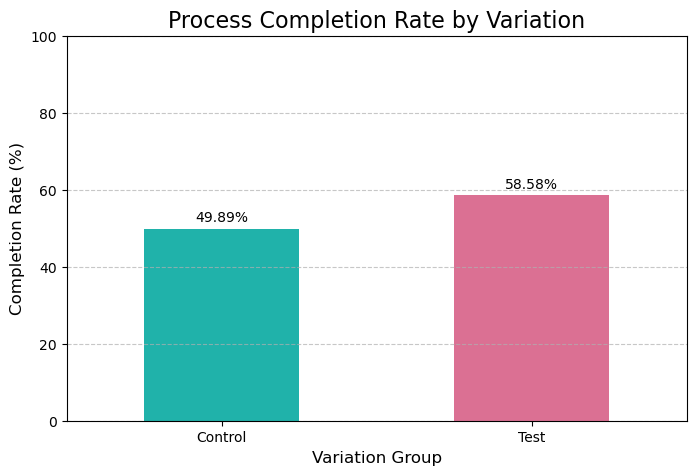


Test Group: 21785 completions out of 37190 visits.
Control Group: 16081 completions out of 32235 visits.

--- KPI 2: Average Time Spent to Complete Process ---
Average Time Spent (minutes) per Completed Process by Variation:
variation
Control    7.600165
Test       8.471799
Name: time_spent_minutes, dtype: float64


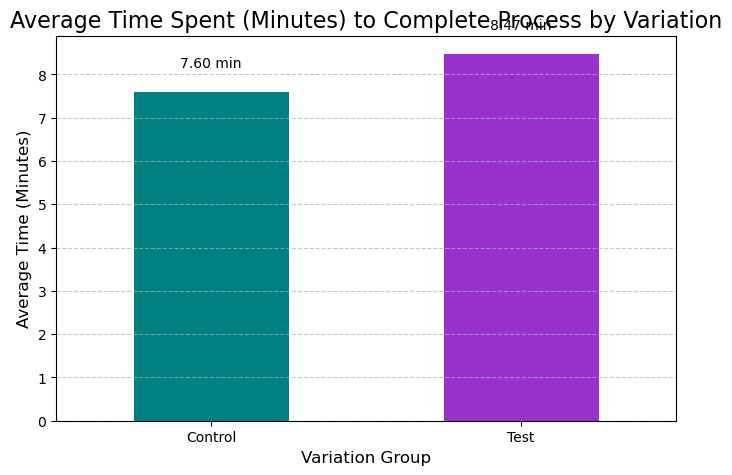


--- KPI 3: Error Rate / Backward Movement ---


C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_2884\1011222605.py:154: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  visits_with_backward_movement = df_full_ab_test.groupby(['client_id', 'visit_id', 'variation']).apply(detect_backward_movement).reset_index(name='has_backward_movement')


Error Rates (Percentage of visits with backward movement) per Variation:
variation
Control    62.596557
Test       69.333154
Name: True, dtype: float64


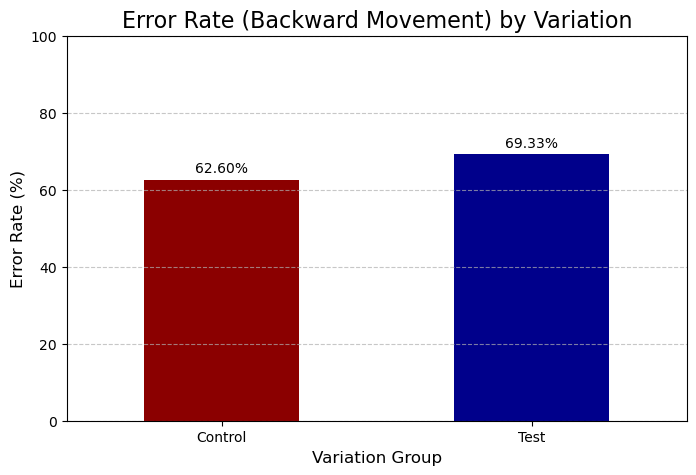


Test Group: 25785 visits with backward movement out of 37190 total visits.
Control Group: 20178 visits with backward movement out of 32235 total visits.

--- KPI Calculation Complete ---

Error saving df_full_ab_test (with KPIs): [Errno 13] Permission denied: 'C:\\Users\\Mahmoud Gobran\\00_Ironhack\\Projects\\vanguard-ab-test\\data\\processed\\df_full_ab_test_cleaned.csv'


In [ ]:
print("\n--- Starting Performance Metrics (KPI) Calculation ---")

# --- Helper Function for Process Step Order ---
# This dictionary maps process steps to a numerical order.
# This is crucial for identifying completion and backward movements.
process_step_order = {
    'start': 0,
    'step_1': 1,
    'step_2': 2,
    'step_3': 3,
    'confirm': 4
}
# Map the 'process_step' column to its numerical order
df_full_ab_test['step_order'] = df_full_ab_test['process_step'].map(process_step_order)


### KPI 1: Completion Rate ###
print("\n--- KPI 1: Completion Rate ---")

# A client is considered to have completed the process if their max_step_order is 'confirm' (4)
# First, find the maximum step reached by each client for each visit.
# It's important to group by client_id AND visit_id because a client can have multiple visits.
# A completion means completing a *single visit*.

# Find the maximum step order for each client and visit
max_steps_per_visit = df_full_ab_test.groupby(['client_id', 'visit_id', 'variation'])['step_order'].max().reset_index()
max_steps_per_visit.rename(columns={'step_order': 'max_step_order'}, inplace=True)

# Determine if a visit resulted in completion (reached 'confirm' step, which is order 4)
# Renamed to 'completed_process' to match previous discussions and avoid potential conflicts
max_steps_per_visit['completed_process'] = (max_steps_per_visit['max_step_order'] == 4)

# --- NEW: Merge 'completed_process' back into the main df_full_ab_test DataFrame ---
# This ensures that each row in df_full_ab_test knows if its visit was completed.
df_full_ab_test = pd.merge(
    df_full_ab_test,
    max_steps_per_visit[['client_id', 'visit_id', 'completed_process']],
    on=['client_id', 'visit_id'],
    how='left' # Use left merge to keep all original rows in df_full_ab_test
)
# Fill NaN values for 'completed_process' with False (e.g., for steps of visits that were never completed)
df_full_ab_test['completed_process'] = df_full_ab_test['completed_process'].fillna(False)


# Calculate completion rate per variation using the 'max_steps_per_visit' (which is aggregated per visit)
# We use max_steps_per_visit here for the rate calculation as it represents unique visits
completion_rates = max_steps_per_visit.groupby('variation')['completed_process'].value_counts(normalize=True).unstack(fill_value=0)


# If 'True' and 'False' columns exist, pick 'True' which means completion
if True in completion_rates.columns:
    completion_rates_final = completion_rates[True] * 100
else: # Case where a group might have 0 completions
    completion_rates_final = pd.Series(0.0, index=completion_rates.index) # Initialize with 0% if no completions

print("Completion Rates per Variation:")
print(completion_rates_final)


# Visualize Completion Rates
plt.figure(figsize=(8, 5))
completion_rates_final.plot(kind='bar', color=['lightseagreen', 'palevioletred'])
plt.title('Process Completion Rate by Variation', fontsize=16)
plt.xlabel('Variation Group', fontsize=12)
plt.ylabel('Completion Rate (%)', fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=0)
for index, value in enumerate(completion_rates_final):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Store completion counts for hypothesis testing later
completions_test = completion_rates.loc['Test', True] * max_steps_per_visit['variation'].value_counts()['Test'] if True in completion_rates.columns else 0
attempts_test = max_steps_per_visit['variation'].value_counts()['Test']
completions_control = completion_rates.loc['Control', True] * max_steps_per_visit['variation'].value_counts()['Control'] if True in completion_rates.columns else 0
attempts_control = max_steps_per_visit['variation'].value_counts()['Control']

print(f"\nTest Group: {int(completions_test)} completions out of {int(attempts_test)} visits.")
print(f"Control Group: {int(completions_control)} completions out of {int(attempts_control)} visits.")


### KPI 2: Average Time Spent to Complete Process ###
print("\n--- KPI 2: Average Time Spent to Complete Process ---")

# Filter for only completed visits using the 'completed_process' column we just added
# Ensure you use 'df_full_ab_test' for the filtering, as 'max_steps_per_visit' is aggregated per visit.
# The `completed_process` column is now part of `df_full_ab_test` after the previous merge.
completed_visits_data_points = df_full_ab_test[df_full_ab_test['completed_process'] == True].copy()

if not completed_visits_data_points.empty:
    # For each completed visit, find the start time and end time
    # Start time is the 'start' step (order 0), End time is the 'confirm' step (order 4)
    start_times = completed_visits_data_points[completed_visits_data_points['step_order'] == 0].groupby(['client_id', 'visit_id'])['date_time'].min()
    end_times = completed_visits_data_points[completed_visits_data_points['step_order'] == 4].groupby(['client_id', 'visit_id'])['date_time'].max()

    # Calculate duration for each completed visit
    duration_per_visit = (end_times - start_times).dt.total_seconds() / 60 # Duration in minutes
    
    # Convert the Series to a DataFrame and reset index to prepare for merge
    # This DataFrame `df_visit_durations` will have one row per completed visit, with its calculated duration.
    df_visit_durations = duration_per_visit.reset_index(name='time_spent_minutes')

    # --- NEW: Merge 'time_spent_minutes' back into the main df_full_ab_test DataFrame ---
    # Merge the calculated duration for each completed visit back into df_full_ab_test.
    # For rows in df_full_ab_test that correspond to non-completed visits, 'time_spent_minutes' will be NaN.
    df_full_ab_test = pd.merge(
        df_full_ab_test,
        df_visit_durations[['client_id', 'visit_id', 'time_spent_minutes']],
        on=['client_id', 'visit_id'],
        how='left' # Use left merge to keep all original rows in df_full_ab_test
    )
    # Note: We don't fillna for time_spent_minutes here as NaN correctly indicates non-completed visits.


    # Calculate average duration per variation for COMPLETED visits ONLY
    # We need to ensure we're only averaging for visits that actually completed and thus have a time_spent_minutes value
    average_duration_per_variation = df_full_ab_test[df_full_ab_test['completed_process'] == True].groupby('variation')['time_spent_minutes'].mean()
    
    print("Average Time Spent (minutes) per Completed Process by Variation:")
    print(average_duration_per_variation)

    # Visualize Average Time Spent
    plt.figure(figsize=(8, 5))
    average_duration_per_variation.plot(kind='bar', color=['teal', 'darkorchid'])
    plt.title('Average Time Spent (Minutes) to Complete Process by Variation', fontsize=16)
    plt.xlabel('Variation Group', fontsize=12)
    plt.ylabel('Average Time (Minutes)', fontsize=12)
    plt.xticks(rotation=0)
    for index, value in enumerate(average_duration_per_variation):
        plt.text(index, value + 0.5, f'{value:.2f} min', ha='center', va='bottom', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    # This else block will likely not be hit if you have any completed visits as confirmed earlier
    print("No completed visits found for time spent calculation.")


### KPI 3: Error Rate / Backward Movement ###
print("\n--- KPI 3: Error Rate / Backward Movement ---")

# Define a function to detect backward movements within a visit
def detect_backward_movement(df_visit):
    # Sort by date_time to ensure correct order
    df_visit = df_visit.sort_values(by='date_time')
    # Calculate the difference in step_order for consecutive steps
    df_visit['step_diff'] = df_visit['step_order'].diff()
    # A backward movement occurs if step_diff is negative
    return (df_visit['step_diff'] < 0).any()

# Apply the function to each visit group
# This will iterate through each client_id and visit_id combination
visits_with_backward_movement = df_full_ab_test.groupby(['client_id', 'visit_id', 'variation']).apply(detect_backward_movement).reset_index(name='has_backward_movement')

# --- NEW: Merge 'has_backward_movement' back into the main df_full_ab_test DataFrame ---
# This ensures that each row in df_full_ab_test knows if its visit had backward movement.
df_full_ab_test = pd.merge(
    df_full_ab_test,
    visits_with_backward_movement[['client_id', 'visit_id', 'has_backward_movement']],
    on=['client_id', 'visit_id'],
    how='left' # Use left merge to keep all original rows in df_full_ab_test
)
# Fill NaN values for 'has_backward_movement' with False (e.g., for visits with only one step, or no backward movement)
df_full_ab_test['has_backward_movement'] = df_full_ab_test['has_backward_movement'].fillna(False)


# Calculate the proportion of visits with backward movement per variation
# We use visits_with_backward_movement here for the rate calculation as it represents unique visits
error_rates = visits_with_backward_movement.groupby('variation')['has_backward_movement'].value_counts(normalize=True).unstack(fill_value=0)

# The 'True' column indicates visits with backward movement (errors)
if True in error_rates.columns:
    error_rates_final = error_rates[True] * 100
else: # Case where a group might have 0 errors
    error_rates_final = pd.Series(0.0, index=error_rates.index) # Initialize with 0% if no errors


print("Error Rates (Percentage of visits with backward movement) per Variation:")
print(error_rates_final)

# Visualize Error Rates
plt.figure(figsize=(8, 5))
error_rates_final.plot(kind='bar', color=['darkred', 'darkblue'])
plt.title('Error Rate (Backward Movement) by Variation', fontsize=16)
plt.xlabel('Variation Group', fontsize=12)
plt.ylabel('Error Rate (%)', fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=0)
for index, value in enumerate(error_rates_final):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Store error counts for hypothesis testing later
errors_test = error_rates.loc['Test', True] * visits_with_backward_movement['variation'].value_counts()['Test'] if True in error_rates.columns else 0
total_visits_test = visits_with_backward_movement['variation'].value_counts()['Test']
errors_control = error_rates.loc['Control', True] * visits_with_backward_movement['variation'].value_counts()['Control'] if True in error_rates.columns else 0
total_visits_control = visits_with_backward_movement['variation'].value_counts()['Control']

print(f"\nTest Group: {int(errors_test)} visits with backward movement out of {int(total_visits_test)} total visits.")
print(f"Control Group: {int(errors_control)} visits with backward movement out of {int(total_visits_control)} total visits.")

print("\n--- KPI Calculation Complete ---")


In [5]:
# --- Save the DataFrame with calculated KPIs for Further Analysis and Tableau ---
# This save now occurs *after* ALL KPI columns have been merged into df_full_ab_test.
processed_data_path = r'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed'
os.makedirs(processed_data_path, exist_ok=True) # Ensure the directory exists

output_file_name = 'df_full_ab_test_cleaned.csv' # This file will now contain all KPIs!
output_full_path = os.path.join(processed_data_path, output_file_name)

try:
    df_full_ab_test.to_csv(output_full_path, index=False)
    print(f"\nSuccessfully saved df_full_ab_test (with KPIs) to: {output_full_path}")
    # Optional: Display info to confirm new columns are present
    print("\nInfo of saved DataFrame (check for new KPI columns):")
    df_full_ab_test.info() # This line will confirm if the columns are there
except Exception as e:
    print(f"\nError saving df_full_ab_test (with KPIs): {e}")


Successfully saved df_full_ab_test (with KPIs) to: C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed\df_full_ab_test_cleaned.csv

Info of saved DataFrame (check for new KPI columns):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302289 entries, 0 to 302288
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   client_id              302289 non-null  int64         
 1   visitor_id             302289 non-null  object        
 2   visit_id               302289 non-null  object        
 3   process_step           302289 non-null  object        
 4   date_time              302289 non-null  datetime64[ns]
 5   variation              302289 non-null  object        
 6   clnt_tenure_yr         302289 non-null  float64       
 7   clnt_tenure_mnth       302289 non-null  float64       
 8   clnt_age               302289 non-null  float64       
 9   gendr        

In [7]:
def quick_data_report(df, file_path="df_name.txt", max_unique=50):
    with open(file_path, "w", encoding="utf-8") as f:
        def p(*args): print(*args, file=f)

        p("=== Shape (rows, columns) ===")
        p(df.shape)

        p("\n=== Column Names ===")
        p(df.columns.tolist())

        p("\n=== Data Types ===")
        p(df.dtypes)

        p("\n=== Missing Values (per column) ===")
        p(df.isnull().sum())

        p("\n=== Duplicate Rows ===")
        p(df.duplicated().sum())

        p("\n=== Unique Values (per column) ===")
        p(df.nunique())

        p("\n=== DataFrame Info ===")
        df.info(buf=f)

        p("\n=== Descriptive Statistics (including non-numeric) ===")
        p(df.describe(include='all'))

        p("\n=== First 5 Rows ===")
        p(df.head())

        p("\n=== Last 5 Rows ===")
        p(df.tail())

        p("\n=== Random Sample of 5 Rows ===")
        p(df.sample(5))

        p("\n=== Value Counts (for columns with 50 or fewer unique values) ===")
        for col in df.columns:
            if df[col].nunique() <= max_unique:
                p(f"\n--- {col} ---")
                p(df[col].value_counts())


In [10]:
quick_data_report(df_full_ab_test, file_path="report_df_full_ab_test.txt")
quick_data_report(completed_visits_data_points, file_path="report_completed_visits_data_points.txt")
quick_data_report(max_steps_per_visit, file_path="report_max_steps_per_visit.txt")
quick_data_report(df_visit_durations, file_path="report_df_visit_durations.txt")
quick_data_report(visits_with_backward_movement, file_path="report_visits_with_backward_movement.txt")



In [12]:
bal_quantiles = df_full_ab_test['bal'].quantile([0, 0.25, 0.5, 0.75, 1]).values
bal_quantiles

array([   23789.44,    40995.41,    69009.64,   151026.5 , 16320040.15])

DataFrame 'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed\df_full_ab_test_cleaned.csv' loaded successfully.
Shape of the DataFrame: (302289, 18)
First 5 rows of df_full_ab_test_cleaned:
   client_id             visitor_id                      visit_id process_step            date_time variation  clnt_tenure_yr  clnt_tenure_mnth  clnt_age    gendr  num_accts       bal  calls_6_mnth  logons_6_mnth  step_order  completed_process  time_spent_minutes  has_backward_movement
0        555  402506806_56087378777  637149525_38041617439_716659        start  2017-04-15 12:57:00      Test             3.0              46.0      29.5  Unknown        2.0  25454.66           2.0            6.0           0               True                 3.0                   True
1        555  402506806_56087378777  637149525_38041617439_716659       step_2  2017-04-15 12:58:00      Test             3.0              46.0      29.5  Unknown        2.0  25454.66           2.0            6

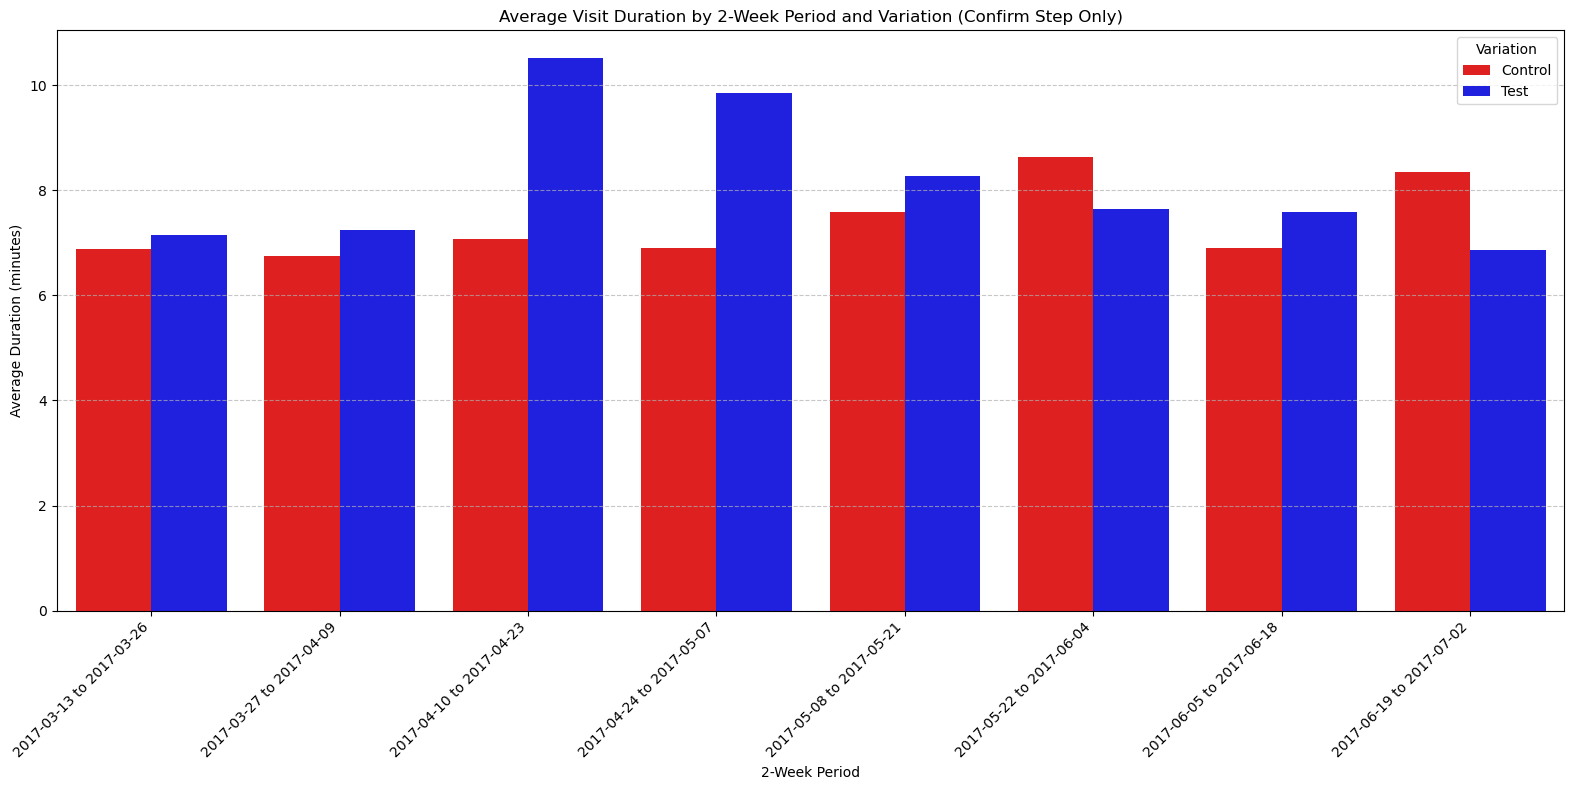

Chart for Average Visit Duration by 2-Week Period and Variation (Confirm Step Only) generated.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Data Loading Section (from previous fix, ensuring df_full_ab_test_cleaned is loaded) ---
processed_data_path = r'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed'
input_file_name = 'df_full_ab_test_cleaned.csv'
input_full_path = os.path.join(processed_data_path, input_file_name)

df_full_ab_test_cleaned = pd.read_csv(input_full_path)

print(f"DataFrame '{input_full_path}' loaded successfully.")
print(f"Shape of the DataFrame: {df_full_ab_test_cleaned.shape}")
print("First 5 rows of df_full_ab_test_cleaned:")
print(df_full_ab_test_cleaned.head())
# ---------------------------------------------------------------------------------------------


# --- Chart 4: Average Visit Duration by 2-Week Period and Variation (Confirm Step Only) ---

print("\n--- Average Visit Duration by 2-Week Period and Variation (Confirm Step Only) ---")

# 1. Ensure 'Date Time' is in datetime format
df_full_ab_test_cleaned['date_time'] = pd.to_datetime(df_full_ab_test_cleaned['date_time'])

# 2. Filter for 'confirm' step only
# Assuming the column name for process step is 'Process Step' and the value is 'confirm'
df_confirm_step = df_full_ab_test_cleaned[df_full_ab_test_cleaned['process_step'] == 'confirm'].copy()

# Check if df_confirm_step is empty after filtering
if df_confirm_step.empty:
    print("No data found for 'confirm' step. Please check 'Process Step' column values or column name.")
else:
    # 3. Create '2-Week Period' column
    # Calculate the start of the week for each entry (Monday as start of week)
    df_confirm_step['Week Start'] = df_confirm_step['date_time'].dt.to_period('W').apply(lambda r: r.start_time)

    # Calculate 2-week intervals by identifying the start of the bi-weekly period
    # Get the week number (e.g., from January 1st of the year)
    df_confirm_step['week_num'] = df_confirm_step['date_time'].dt.isocalendar().week.astype(int)
    # Define the start of a 2-week period based on week_num
    # For example, weeks 1 & 2 belong to period 0, weeks 3 & 4 to period 1, etc.
    df_confirm_step['bi_week_group'] = ((df_confirm_step['week_num'] - 1) // 2)

    # Get the earliest date for each bi-week group
    bi_week_start_dates = df_confirm_step.groupby('bi_week_group')['Week Start'].min()

    # Create a mapping from bi_week_group to formatted 2-week period string
    period_labels = {}
    for group_id, start_date in bi_week_start_dates.items():
        end_date = start_date + pd.Timedelta(weeks=2) - pd.Timedelta(days=1)
        period_labels[group_id] = f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}"

    # Apply the labels to the DataFrame
    df_confirm_step['2-Week Period'] = df_confirm_step['bi_week_group'].map(period_labels)

    # 4. Calculate Average Visit Duration per 2-Week Period and Variation
    # Assuming 'Time Spent Minutes' is the column for duration
    avg_duration_by_period = df_confirm_step.groupby(['2-Week Period', 'variation'])['time_spent_minutes'].mean().reset_index()

    # Sort the periods for correct x-axis order
    # Extract actual start dates from the '2-Week Period' string for sorting
    avg_duration_by_period['sort_key'] = pd.to_datetime(avg_duration_by_period['2-Week Period'].str.split(' to ').str[0])
    avg_duration_by_period = avg_duration_by_period.sort_values(by='sort_key').drop(columns='sort_key')


    # Plotting the grouped bar chart
    plt.figure(figsize=(16, 8)) # Increased figure size for better readability of x-axis labels
    sns.barplot(
        data=avg_duration_by_period,
        x='2-Week Period',
        y='time_spent_minutes',
        hue='variation',
        palette={'Control': 'red', 'Test': 'blue'} # Matching your Tableau colors
    )

    plt.title('Average Visit Duration by 2-Week Period and Variation (Confirm Step Only)')
    plt.xlabel('2-Week Period')
    plt.ylabel('Average Duration (minutes)')
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Variation')
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    print("Chart for Average Visit Duration by 2-Week Period and Variation (Confirm Step Only) .")


--- Average Time Spent per Step (Seconds) ---


C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_2884\593467030.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_time_per_step = df_full_ab_test_cleaned.dropna(subset=['process_step']).groupby(['process_step', 'variation'])['time_spent_minutes'].mean().reset_index()


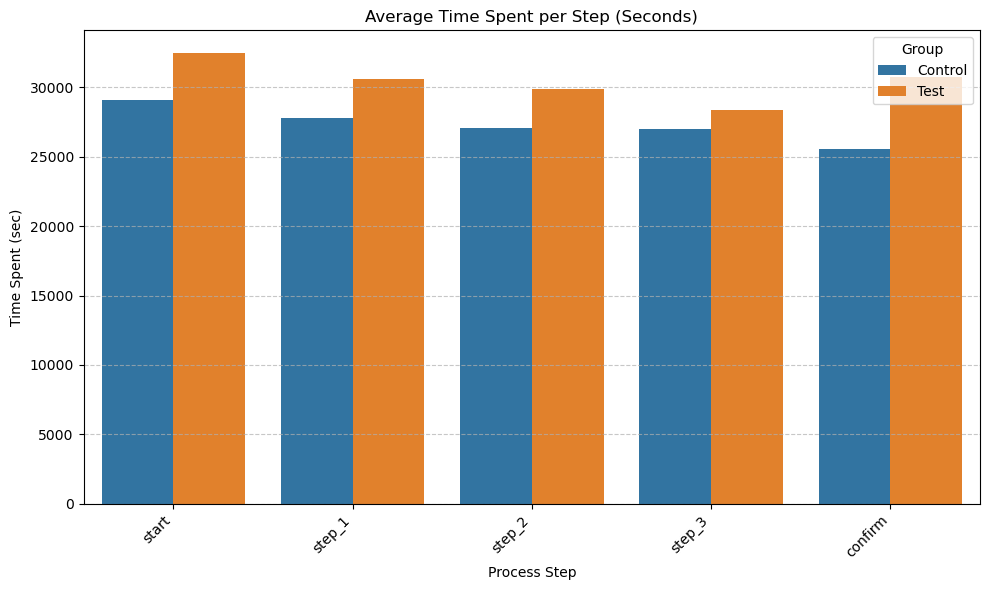

Chart for Average Time Spent per Step (Seconds) generated.


In [22]:
# --- Chart 5: Average Time Spent per Step (Seconds) ---

print("\n--- Average Time Spent per Step (Seconds) ---")

# Assuming 'Time Spent Minutes' is in minutes, convert to seconds
df_full_ab_test_cleaned['time_spent_minutes'] = df_full_ab_test_cleaned['time_spent_minutes'] * 60

# Define the desired order of process steps for the x-axis
# Based on the image: 'start', 'step_1', 'step_2', 'step_3', 'confirm'
process_step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Convert 'Process Step' to a categorical type with the specified order
df_full_ab_test_cleaned['process_step'] = pd.Categorical(
    df_full_ab_test_cleaned['process_step'],
    categories=process_step_order,
    ordered=True
)

# Calculate the average time spent per step and variation
# Ensure we drop any NaN values in 'Process Step' that might occur if categories don't match
avg_time_per_step = df_full_ab_test_cleaned.dropna(subset=['process_step']).groupby(['process_step', 'variation'])['time_spent_minutes'].mean().reset_index()

# Plotting the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_time_per_step,
    x='process_step',
    y='time_spent_minutes',
    hue='variation',
    # Using the colors from image_dba93e.png (a default Seaborn 'tab10' or similar)
    palette={'Control': '#1f77b4', 'Test': '#ff7f0e'} # These are common 'tab10' blue and orange
)

plt.title('Average Time Spent per Step (Seconds)')
plt.xlabel('Process Step')
plt.ylabel('Time Spent (sec)')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Group') # Changed legend title to 'Group' as per image_dba93e.png
plt.tight_layout()
plt.show()

print("Chart for Average Time Spent per Step (Seconds) generated.")

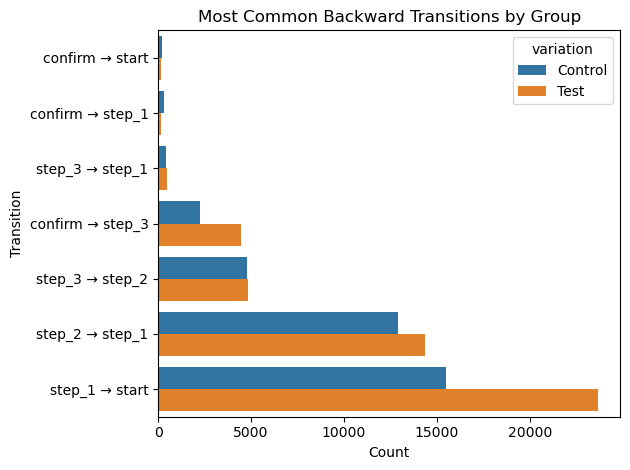

In [23]:
#Error Rates: If there's a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

# Assign numeric order to steps
step_order = {
    'start': 0,
    'step_1': 1,
    'step_2': 2,
    'step_3': 3,
    'confirm': 4
}
df_full_ab_test['step_num'] = df_full_ab_test['process_step'].map(step_order)

# Sort and calculate previous step
df = df_full_ab_test.sort_values(['visit_id', 'date_time']).copy()
df['prev_step'] = df.groupby('visit_id')['process_step'].shift(1)
df['prev_step_num'] = df.groupby('visit_id')['step_num'].shift(1)

# Identify backward transitions
df['is_backward'] = df['step_num'] < df['prev_step_num']
backward_transitions = df[df['is_backward']].copy()
backward_transitions['transition'] = backward_transitions['prev_step'] + ' → ' + backward_transitions['process_step']

# Filter out specific transitions
excluded_transitions = ["step_3 → start", "step_2 → start", "confirm → step_2"]
backward_transitions = backward_transitions[~backward_transitions['transition'].isin(excluded_transitions)]

# Count transitions by variation
transition_counts_by_group = backward_transitions.groupby(['variation', 'transition']).size().reset_index(name='count')

# Plot backward transitions (ordered by count)
transition_counts_by_group = backward_transitions.groupby(['variation', 'transition']).size().reset_index(name='count')

# Sort transitions by total count (summing across variations)
transition_order = (
    transition_counts_by_group
    .groupby('transition')['count']
    .sum()
    .sort_values(ascending=True)
    .index
)

# Plot with ordered transitions
sns.barplot(
    data=transition_counts_by_group,
    x='count',
    y='transition',
    hue='variation',
    order=transition_order
)
plt.title('Most Common Backward Transitions by Group')
plt.xlabel('Count')
plt.ylabel('Transition')
plt.tight_layout()
plt.show()
